# Event Finder

The goal of this notebook is to develop a generalized event finder. Based on user selected variable and event definitions, this notebook will search all simulations to find these events. 
Inputs:

* Domain,a custom shapefile
* One variable
* Low and/or High thresholds
* Duration 
* GWL

## Make Selections

Before running this notebook, make the following selections for variables, domain, and GWLs.

1. Select a timescale - this will impact which downscaling methods are available and which variables are availble.

In [1]:
timescale = "monthly" # options are hourly, daily or monthly

2. Select a variable - the code below displays which variables are available based on your timescale options

In [18]:
# import function 
from climakitae.explore.agnostic import (
  show_available_vars
)

In [19]:
# display variables available for this analysis 
# only showing dynamical because statistical has a smaller subset that is in the larger dynamical subset
# only difference is max/min RH is availble in statistical and not in dynamical 
show_available_vars("Dynamical",timescale)

['Air Temperature at 2m',
 'Precipitation (total)',
 'Relative humidity',
 'Dew point temperature',
 'Mean wind speed at 10m',
 'Maximum wind speed at 10m',
 'Surface Pressure',
 'Specific humidity at 2m',
 'Surface skin temperature',
 'Maximum air temperature at 2m',
 'Minimum air temperature at 2m',
 'Instantaneous downwelling longwave flux at bottom',
 'Instantaneous downwelling shortwave flux at bottom',
 'Shortwave flux at the surface',
 'Longwave flux at the surface',
 'Sensible heat flux at the surface',
 'Latent heat flux at the surface',
 'Ground heat flux',
 'Snowfall',
 'Liquid water path',
 'Evaporation',
 'Ice water path',
 'Maximum precipitation']

In [20]:
# make selection from list above
event_variable = "Air Temperature at 2m"

3. Define event in the form of threshold_1 < event < threshold_2

In [21]:
# you may leave up to one of these thresholds as None
threshold_1 = 90
threshold_2 = None

4. Define event duration 

In [22]:
duration = 1 # units are based on the timescale - if timescale is monthly this is one month

5. Select a GWL

In [23]:
# current options 0.8, 1.0, 1.2, 1.5, 2.0, 2.5, 3.0, 4.0
gwl = "2.0"

6. Select Spatial Domain - provide a shapefile to clip data to

In [24]:
# edit path below and filename for shapefile to use
shapefile_filename = 'PajaroRiverWatershed.zip'
spatial_domian = "Pajaro" # name will appear in title

7. Select Resolution - select the the model resolution (3km, 9km, 45 km)

In [25]:
resolution = "3 km"

## Import libraries & define functions

In [26]:
pip install xsdba

Note: you may need to restart the kernel to use updated packages.


In [27]:
import climakitae as ck 
from climakitae.core.data_interface import (
    get_data_options, 
    get_subsetting_options, 
    get_data
)

import xarray as xr
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [28]:
def clip_to_shapefile(da, shapefile):
    """
    Clip a DataArray to the boundaries of a shapefile.

    Parameters:
    - da: xarray DataArray to be clipped
    - shapefile: path to the shapefile

    Returns:
    - Clipped DataArray
    """
    # Read the shapefile using geopandas
    gdf = gpd.read_file(shapefile)

    # Ensure the DataArray has a CRS set
    #da.rio.write_crs("epsg:2228", inplace=True)

    # Clip the DataArray using the shapefile geometry
    clipped_da = da.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)

    return clipped_da

## Pull Data

### Dynamical Downscaling (wrf)

In [29]:
# WRF downscaling
wrf_data =get_data(
        variable = event_variable, 
        downscaling_method = "Dynamical", 
        resolution = resolution, 
        timescale = timescale, 
        # Modify your approach 
        approach = "Warming Level",
        warming_level= float(gwl)
    )

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
! Returned data array is large. Operations could take up to 5x longer than 1GB of data!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



In [30]:
# rename lat lon
wrf_data=wrf_data.rename({'x': 'longitude','y': 'latitude'})

### Statistical Downscaling (loca2)

In [31]:
# grab correct variable name for loca 2 
loca_variable = [event_variable]
# temperature
if loca_variable[0] == "Air Temperature at 2m":
    loca_variable = ["Maximum air temperature at 2m", "Minimum air temperature at 2m"]
# relative humidity
if loca_variable[0] == "Relative humidity":
    loca_variable = ["Minimum relative humidity", "Maximum relative humidity"]

In [32]:
# statistical - loca2 downscaling xvariable
loca_data = [get_data(
        variable = GETVAR, 
        downscaling_method = "Statistical", 
        resolution = resolution, 
        timescale = timescale, 
        # Modify your approach 
        approach = "Warming Level",
        warming_level= float(gwl)
    ) for GETVAR in loca_variable]

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



In [33]:
# if we need to average 
if loca_data[0] is not None:
    # temperature
    if event_variable == "Air Temperature at 2m":
        loca_data = (loca_data[0] + loca_data[1]) / 2
        loca_data.name = "Air Temperature at 2m"
        
    # relative humidity
    if event_variable == "Relative humidity":
        loca_data = (loca_data[0] + loca_data[1]) / 2
        loca_data.name = "Relative humidity"

In [34]:
# unlist if needed
if type(loca_data) == list:
    loca_data = loca_data[0]

# now merge
# first check if there is valid loca data - requires that both x and y have valid data
if loca_data is None:
    # set to wrf
    loca_data = wrf_data
    # replace with all NaNs
    loca_data = loca_data*np.nan
else:
    loca_data=loca_data.rename({'lon': 'longitude','lat': 'latitude'})

## Downsize Data

In [35]:
# clip to shapefile
wrf_data = clip_to_shapefile(wrf_data, shapefile_filename)
loca_data = clip_to_shapefile(loca_data, shapefile_filename)

In [36]:
# average across domain (we want single timeseries)
wrf_data = wrf_data.mean(['longitude','latitude'])
loca_data = loca_data.mean(['longitude','latitude'])

## Import Data

In [37]:
loca_data = loca_data.compute()
wrf_data = wrf_data.compute()

## Plot Results (Yay!)

In [1]:
# determine the simulation names
lsims = loca_data.simulation.values
wsims = wrf_data.simulation.values
sims = lsims.tolist() + wsims.tolist()
unique_models = list(set([s.split("_")[1] for s in sims]))

NameError: name 'loca_data' is not defined

In [38]:
# create a pallette of colors
col_palette  = sns.color_palette("viridis", n_colors=len(unique_models))

In [39]:
# list of all possible markers
markers = [
    "o", "<","s", "^", "D", "X", "*", "P", "D", "h",">"
]

In [40]:
# set markers and colors
model_colors = dict(zip(unique_models, col_palette))
model_markers = dict(zip(unique_models, markers*4))

In [41]:
# set font size for plot
plt.rcParams.update({'font.size': 14})

In [54]:
wrf_data

<xarray.DataArray np.str_('Air Temperature at 2m') (warming_level: 1,
                                                    time_delta: 360,
                                                    simulation: 8)> Size: 12kB
array([[[281.69876, 282.50223, 282.4281 , ..., 279.56616, 281.77484,
         285.40628],
        [284.1839 , 285.20047, 283.79834, ..., 284.52042, 280.86035,
         285.90143],
        [284.6755 , 283.32785, 286.22113, ..., 284.4837 , 284.01492,
         288.1098 ],
        ...,
        [293.70984, 291.56125, 290.38177, ..., 290.96063, 290.04605,
         293.28482],
        [288.386  , 286.66663, 287.93213, ..., 288.22144, 286.8486 ,
         285.9675 ],
        [282.4234 , 283.4842 , 283.59213, ..., 285.7317 , 283.2978 ,
         282.97745]]], dtype=float32)
Coordinates:
  * warming_level      (warming_level) float64 8B 2.0
  * time_delta         (time_delta) float64 3kB -180.0 -179.0 ... 178.0 179.0
    centered_year      (simulation) int64 64B 2043 2049 2034 ... 2053 2045 2040
  * simulation         (simulation) <U44 1kB 'WRF_CESM2_r11i1p1f1_historical+...
    Lambert_Conformal  int64 8B 0
Attributes:
    variable_id:           t2
    extended_description:  Temperature of the air 2m above Earth's surface. T...
    units:                 K
    data_type:             Gridded
    resolution:            3 km
    frequency:             monthly
    location_subset:       ['entire domain']
    approach:              Warming Level
    downscaling_method:    Dynamical
    warming_level_window:  +/- 15 years from centered year
    institution:           UCLA

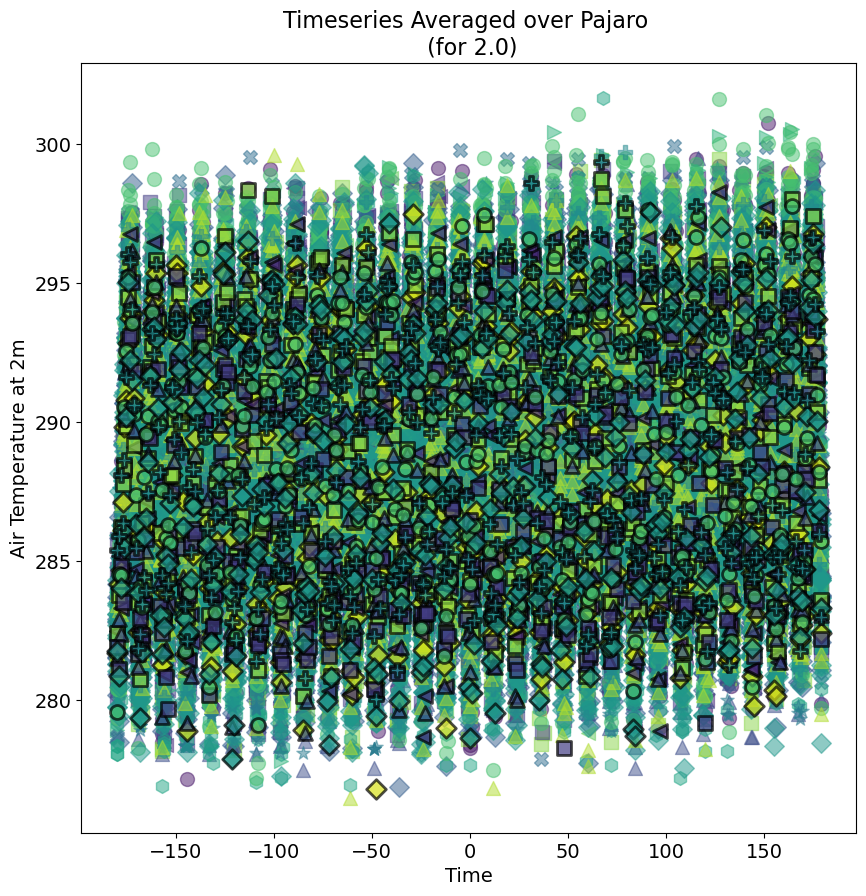

In [55]:
# create the scatterplot
# plot setup
figure = plt.figure(figsize=(10, 10))
ax = figure.add_subplot(111)
ax.set_title(f"Timeseries Averaged over {spatial_domian} \n (for {gwl})", fontsize=16)
ax.set_xlabel(f"Time")
ax.set_ylabel(f"{event_variable}")

for i, loca_sim in enumerate(loca_data.simulation.values):
    model = loca_sim.split("_")[1]
    color = model_colors[model]
    marker = model_markers[model]
    # rotate through markers
    ax.scatter(loca_data["time_delta"], loca_data.sel(simulation=loca_sim), color = color, label=None, marker=marker, s=100, alpha=0.5)
    
for i, wrf_sim in enumerate(wrf_data.simulation.values):
    model = wrf_sim.split("_")[1]
    color = model_colors[model]
    marker = model_markers[model]
    ax.scatter(wrf_data["time_delta"], wrf_data.sel(simulation=wrf_sim), color = color, label=None, linewidths=2, edgecolor='black', marker=marker, s=100, alpha=0.7)


In [67]:
loca_data.sel(simulation=loca_sim).values.squeeze()

array([280.72293, 283.4358 , 282.80814, 286.74158, 287.92905, 293.52997,
       294.72635, 295.44058, 291.72333, 291.2192 , 285.4875 , 287.194  ,
       284.36298, 282.4519 , 283.1218 , 287.73193, 286.5621 , 293.55362,
       294.2318 , 293.43088, 293.57965, 289.35196, 283.2433 , 278.47458,
       282.39526, 286.41727, 285.828  , 286.71027, 289.71152, 292.25674,
       295.8465 , 294.176  , 293.25668, 292.94147, 283.7178 , 279.55356,
       281.0956 , 282.03082, 283.463  , 286.9732 , 287.94388, 292.80038,
       295.3779 , 293.921  , 293.707  , 293.47467, 285.8906 , 283.3181 ,
       282.39105, 283.5831 , 286.27295, 286.7552 , 293.6443 , 292.48157,
       296.57056, 292.09827, 293.87662, 291.7434 , 287.49557, 282.27728,
       282.0631 , 282.05292, 284.00156, 285.82425, 290.68155, 290.35895,
       295.4459 , 295.3319 , 297.362  , 291.2281 , 286.03766, 287.53296,
       281.59158, 283.21924, 283.62875, 285.30396, 290.1496 , 292.54968,
       296.70334, 296.5234 , 295.81744, 290.21106, 

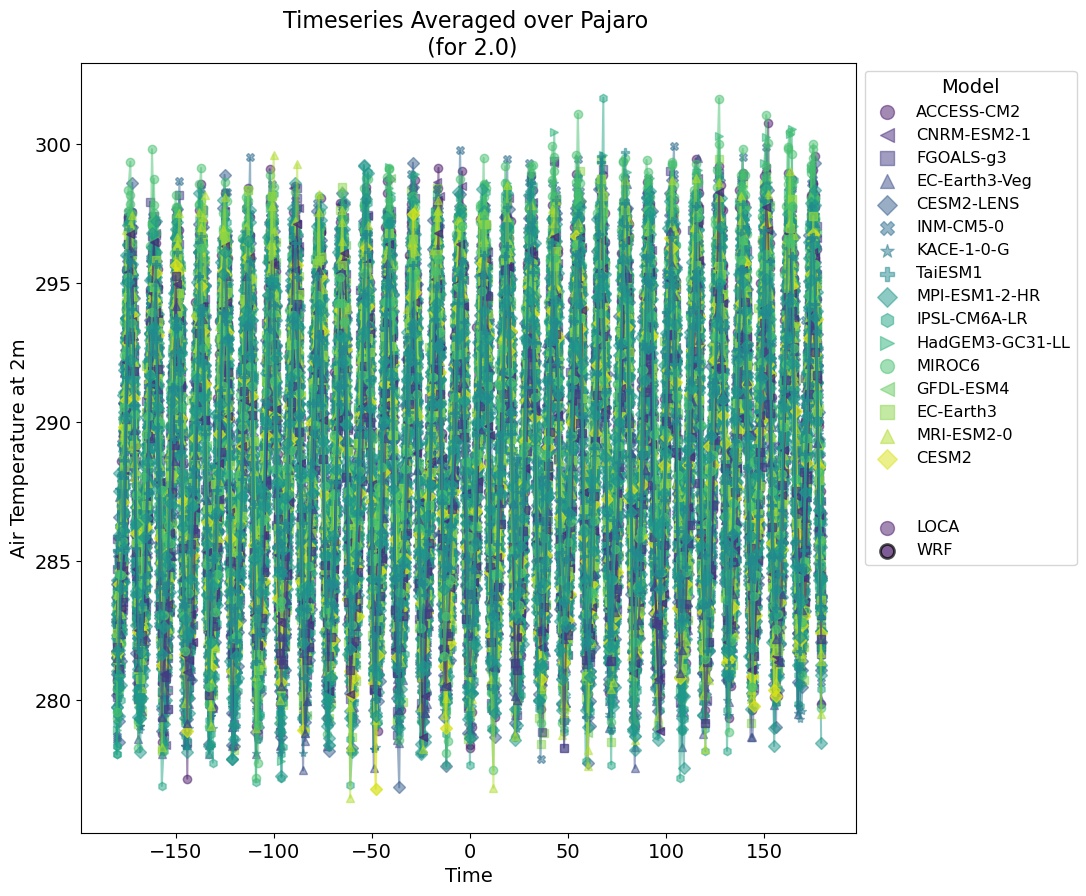

In [72]:
# create the scatterplot
# plot setup
figure = plt.figure(figsize=(10, 10))
ax = figure.add_subplot(111)
ax.set_title(f"Timeseries Averaged over {spatial_domian} \n (for {gwl})", fontsize=16)
ax.set_xlabel(f"Time")
ax.set_ylabel(f"{event_variable}")

for i, loca_sim in enumerate(loca_data.simulation.values):
    model = loca_sim.split("_")[1]
    color = model_colors[model]
    marker = model_markers[model]
    # rotate through markers
    ax.plot(loca_data["time_delta"], loca_data.sel(simulation=loca_sim).values.squeeze(), color = color, label=None, marker=marker, alpha=0.5)
    
for i, wrf_sim in enumerate(wrf_data.simulation.values):
    model = wrf_sim.split("_")[1]
    color = model_colors[model]
    marker = model_markers[model]
    ax.plot(wrf_data["time_delta"], wrf_data.sel(simulation=wrf_sim).values.squeeze(), color = color, label=None, marker=marker,  alpha=0.7)

for model in unique_models:
    ax.scatter([], [], color=model_colors[model], label=model, marker=model_markers[model], s=100, alpha=0.5)
ax.scatter([], [], color=model_colors[unique_models[0]], label='  ', marker=model_markers[unique_models[0]], s=100, alpha=0.0)
ax.scatter([], [], color=model_colors[unique_models[0]], label=' ', marker=model_markers[unique_models[0]], s=100, alpha=0.0)

ax.scatter([], [], color=model_colors[unique_models[0]], label='LOCA', marker=model_markers[unique_models[0]], s=100, alpha=0.5)
ax.scatter([], [], color=model_colors[unique_models[0]], label='WRF', marker=model_markers[unique_models[0]], linewidths=2, edgecolor='black', s=100, alpha=0.7)

ax.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')